In [75]:
# Problem 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [76]:
def image_binarization(img):
    # 应用Otsu方法选择阈值
    ret, img_binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 创建一个全黑的图像
    mask = np.zeros_like(img_binary)
    
    # 只保留指定区域 (y轴90到170, x轴50到360)
    mask[90:170, 50:360] = img_binary[90:170, 50:360]
    
    return mask

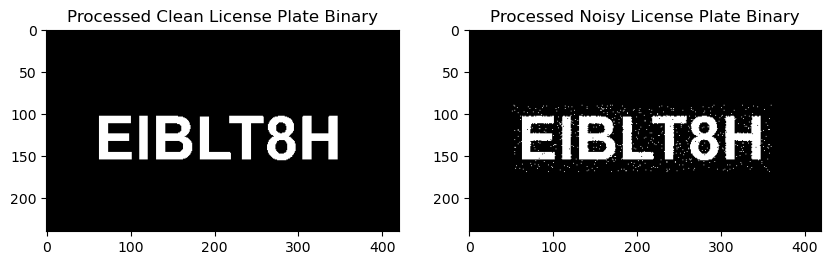

True

In [77]:
# 读取干净的车牌图像
clean_plate = cv2.imread('./figs/pro2_license_plate_clean.png', 0)

# 读取噪声车牌图像
noisy_plate = cv2.imread('./figs/pro2_license_plate_noisy.png', 0)

# 检查图像是否正确读取
if clean_plate is None:
    raise ValueError("C!!")
if noisy_plate is None:
    raise ValueError("N!!")

# 处理图像
binary_clean = image_binarization(clean_plate)
binary_noisy = image_binarization(noisy_plate)

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Processed Clean License Plate Binary')
plt.imshow(binary_clean, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Processed Noisy License Plate Binary')
plt.imshow(binary_noisy, cmap='gray')
plt.show()

# 保存结果图像
cv2.imwrite('./figs/binary_clean.png', binary_clean)
cv2.imwrite('./figs/binary_noisy.png', binary_noisy)

In [78]:
def read_templates(template_dir):
    templates = []
    for filename in os.listdir(template_dir):
        if filename.endswith(".png"):
            template_path = os.path.join(template_dir, filename)
            template_img = cv2.imread(template_path, 0)
            templates.append((filename.split('.')[0], template_img))
    return templates

# 模板图像文件夹路径
template_dir = './figs/Templates'

# 读取模板图像
templates = read_templates(template_dir)

# 检查模板图像是否正确读取
if not templates:
    raise ValueError("No template images found.")


In [79]:
# 读取干净的车牌图像
binary_clean = cv2.imread('./figs/binary_clean.png', 0)
# 读取噪声车牌图像
binary_noisy = cv2.imread('./figs/binary_noisy.png', 0)

# 检查图像是否正确读取
if binary_clean is None:
    raise ValueError("Binary clean plate image not found.")
if binary_noisy is None:
    raise ValueError("Binary noisy plate image not found.")


In [80]:
def erode_templates(templates):
    eroded_templates = []
    for char_name, template in templates:
        eroded_template = cv2.erode(template, np.ones((3, 3), np.uint8))
        eroded_templates.append((char_name, eroded_template))
    return eroded_templates

# 侵蚀
eroded_templates = erode_templates(templates)


In [86]:
def character_detection(binary_image, templates):
    detected_characters = []
    for char_name, template in templates:
        # 使用模板匹配进行检测
        result = cv2.matchTemplate(binary_image, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.5  # 设置匹配阈值
        locations = np.where(result >= threshold)  # 获取匹配结果大于阈值的位置
        if len(locations[0]) > 0:
            detected_characters.append((char_name, locations))
    return detected_characters


In [87]:
# 检测干净车牌上的字符
detected_chars_clean = character_detection(binary_clean, eroded_templates)
# 检测噪声车牌上的字符
detected_chars_noisy = character_detection(binary_noisy, eroded_templates)
print(detected_chars_clean, detected_chars_noisy)

[('E', (array([88, 88, 89, 89], dtype=int64), array([182, 183, 182, 183], dtype=int64)))] [('E', (array([88, 89], dtype=int64), array([183, 183], dtype=int64)))]


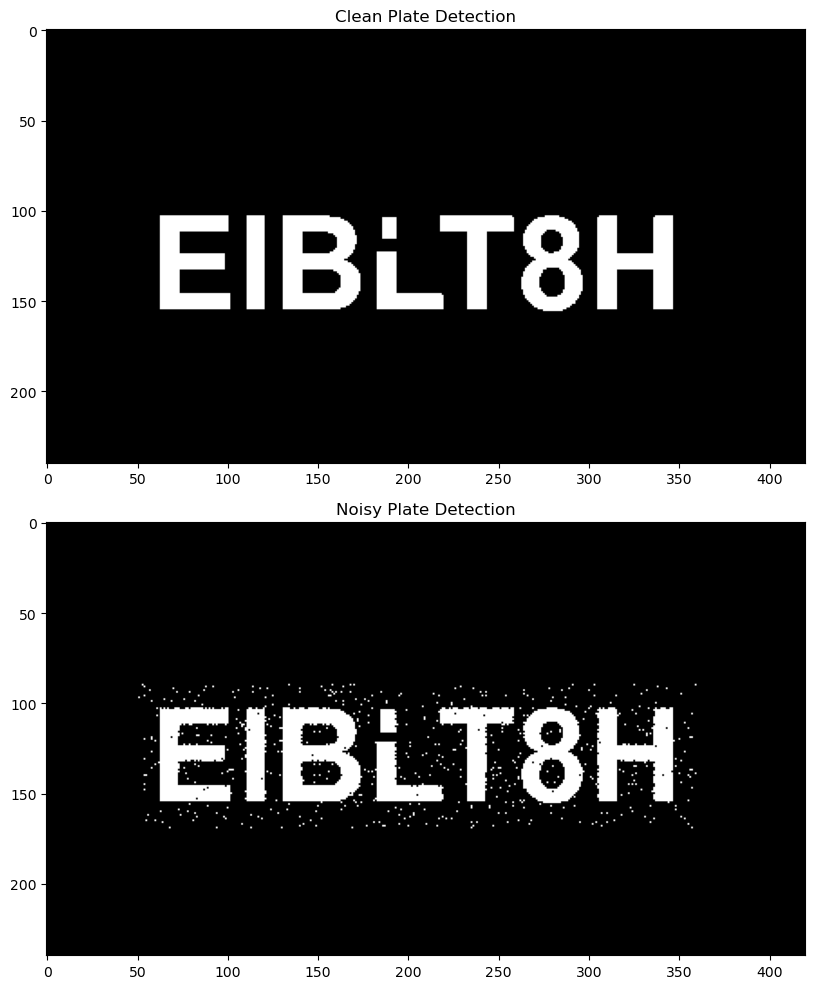

In [88]:
# 可视化干净车牌检测结果
plt.figure(figsize=(15, 10))
for i, (char_name, loc) in enumerate(detected_chars_clean):
    for pt in zip(*loc[::-1]):
        cv2.rectangle(binary_clean, pt, (pt[0] + 20, pt[1] + 30), (0, 0, 255), 2)
    plt.subplot(2, 1, 1)
    plt.imshow(binary_clean, cmap='gray')
    plt.title('Clean Plate Detection')

# 可视化噪声车牌检测结果
for i, (char_name, loc) in enumerate(detected_chars_noisy):
    for pt in zip(*loc[::-1]):
        cv2.rectangle(binary_noisy, pt, (pt[0] + 20, pt[1] + 30), (0, 0, 255), 2)
    plt.subplot(2, 1, 2)
    plt.imshow(binary_noisy, cmap='gray')
    plt.title('Noisy Plate Detection')

plt.tight_layout()
plt.show()


In [90]:
def hit_miss_detection(binary_image, templates):
    detected_characters = []
    foreground_se = np.ones((3, 3), np.uint8)
    background_se = np.zeros((5, 5), np.uint8)
    background_se[1:4, 1:4] = 1

    for char_name, template in templates:
        # 生成击中-击不中结构元素
        fg_se = cv2.erode(template, foreground_se)
        bg_se = cv2.dilate(template, background_se)
        
        # 击中-击不中滤波器
        hitmiss = cv2.morphologyEx(binary_image, cv2.MORPH_HITMISS, fg_se - bg_se)

    return detected_characters


In [92]:
# 使用击中-击不中滤波器检测干净车牌上的字符
detected_chars_clean = hit_miss_detection(binary_clean, eroded_templates)
# 使用击中-击不中滤波器检测噪声车牌上的字符
detected_chars_noisy = hit_miss_detection(binary_noisy, eroded_templates)
print(detected_chars_clean, detected_chars_noisy)

[] []


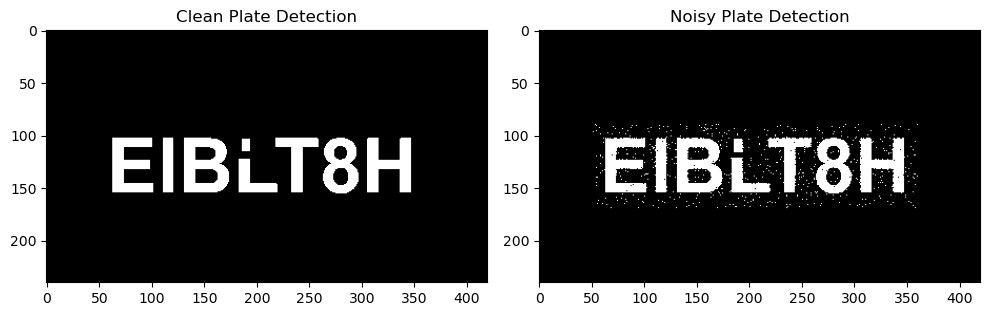

In [93]:
# 在图像上绘制检测到的字符边界框
def draw_detections(image, detections):
    for char_name, hitmiss in detections:
        locations = np.where(hitmiss > 0)
        for pt in zip(*locations[::-1]):
            cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 0, 255), 2)
    return image

# 可视化干净车牌检测结果
binary_clean_detected = draw_detections(binary_clean.copy(), detected_chars_clean)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(binary_clean_detected, cmap='gray')
plt.title('Clean Plate Detection')

# 可视化噪声车牌检测结果
binary_noisy_detected = draw_detections(binary_noisy.copy(), detected_chars_noisy)
plt.subplot(1, 2, 2)
plt.imshow(binary_noisy_detected, cmap='gray')
plt.title('Noisy Plate Detection')

plt.tight_layout()
plt.show()


In [94]:
def rank_filter(image, rank, se):
    return cv2.erode(image, se) if rank == 1 else cv2.dilate(image, se)

def min_rank_filters(binary_image, templates, p1, p2):
    detected_characters = []
    se1 = np.ones((3, 3), np.uint8)  # 前景结构元素
    se2 = np.ones((5, 5), np.uint8)  # 背景结构元素

    for char_name, template in templates:
        rank_filter1 = rank_filter(binary_image, p1, se1)
        rank_filter2 = rank_filter(binary_image, p2, se2)
        min_filter = np.minimum(rank_filter1, rank_filter2)
        
        match = cv2.matchTemplate(min_filter, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.8
        locations = np.where(match >= threshold)
        
        if len(locations[0]) > 0:
            detected_characters.append((char_name, locations))
            
        if len(detected_characters) >= 7:
            break

    return detected_characters


In [97]:
# 使用最小秩滤波器检测噪声车牌上的字符
detected_chars_noisy = min_rank_filters(binary_noisy, eroded_templates, p1=1, p2=1)
print(detected_chars_noisy)

[]


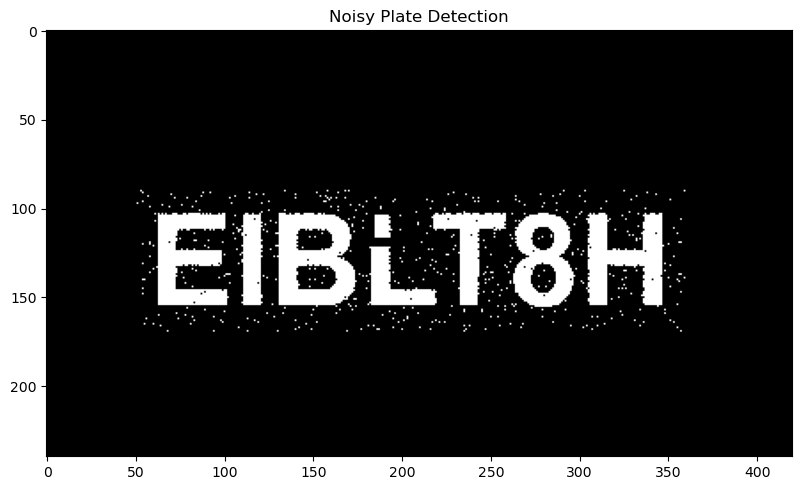

In [98]:
# 在图像上绘制检测到的字符边界框
def draw_detections(image, detections):
    for char_name, locations in detections:
        for pt in zip(*locations[::-1]):
            cv2.rectangle(image, pt, (pt[0] + template.shape[1], pt[1] + template.shape[0]), (0, 0, 255), 2)
    return image

# 可视化噪声车牌检测结果
binary_noisy_detected = draw_detections(binary_noisy.copy(), detected_chars_noisy)
plt.figure(figsize=(10, 5))
plt.imshow(binary_noisy_detected, cmap='gray')
plt.title('Noisy Plate Detection')
plt.tight_layout()
plt.show()
